In [ ]:
!pip install datasets
!pip install transformers
!pip install peft
!pip install evaluate

In [94]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

In [95]:
# The Stanford Sentiment Treebank .The task is to predict the sentiment of a given sentence.
dataset = load_dataset("FinanceMTEB/financial_phrasebank")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 1264
    })
    test: Dataset({
        features: ['text', 'label_text', 'label'],
        num_rows: 1000
    })
})

In [96]:
from datasets import DatasetDict

split = dataset["train"].train_test_split(test_size=0.2, seed=42)
dataset["train"] = split["train"]            # 80% of 1264 → ~1011 rows
dataset["validation"] = split["test"]        # 20% of 1264 → ~253 rows
# keep original test as final test
dataset["test"] = dataset["test"]            # 1000 rows

# Then tokenize all splits
tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

In [97]:
from transformers import AutoModelForSequenceClassification

model_checkpoint = 'roberta-base'

# define label maps
id_label = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

label_id = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}




Robertamodel = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id_label,
    label2id=label_id
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [98]:
Robertamodel

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [99]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    Robertamodel.resize_token_embeddings(len(tokenizer))

In [100]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [101]:

# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1011
    })
    test: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 253
    })
})

In [102]:

# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [103]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [104]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [105]:
# define list of examples
text_list = [
    "The company reported a 15 percent increase in operating profit for the quarter.",
    "Net sales declined compared to the same period last year.",
    "The board announced no changes to its dividend policy.",
    "The acquisition is expected to strengthen the firm’s market position.",
    "Operating profit fell due to higher raw material costs.",
    "No financial details of the agreement were disclosed."
]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = Robertamodel(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id_label[predictions.tolist()])


Untrained model predictions:
----------------------------
The company reported a 15 percent increase in operating profit for the quarter. - Neutral
Net sales declined compared to the same period last year. - Neutral
The board announced no changes to its dividend policy. - Neutral
The acquisition is expected to strengthen the firm’s market position. - Neutral
Operating profit fell due to higher raw material costs. - Neutral
No financial details of the agreement were disclosed. - Neutral


In [106]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np

BASE_MODEL_NAME = model_checkpoint  # "roberta-base"

base_model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL_NAME,
    num_labels=len(id_label),
    id2label=id_label,
    label2id=label_id
)

# Separate args for base eval (so no eval_dataset requirement at init)
base_eval_args = TrainingArguments(
    output_dir="base_eval_tmp",
    per_device_eval_batch_size=16,
    eval_strategy="no",     # IMPORTANT
    report_to="none"
)

eval_split = "test" if "test" in tokenized_dataset else "validation"

base_trainer = Trainer(
    model=base_model,
    args=base_eval_args,
    eval_dataset=tokenized_dataset[eval_split],   # IMPORTANT
    tokenizer=tokenizer,                           # warning only, OK
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

base_eval = base_trainer.evaluate()
base_pred = base_trainer.predict(tokenized_dataset[eval_split])

base_logits = base_pred.predictions
base_y_true = base_pred.label_ids
base_y_pred = np.argmax(base_logits, axis=1)

print("BASE eval:", base_eval)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3447991407.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  base_trainer = Trainer(


BASE eval: {'eval_loss': 1.0664478540420532, 'eval_model_preparation_time': 0.003, 'eval_accuracy': {'accuracy': 0.612}, 'eval_runtime': 3.2384, 'eval_samples_per_second': 308.791, 'eval_steps_per_second': 19.454}


In [107]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['query'])

In [108]:
peft_config

LoraConfig(task_type='SEQ_CLS', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, peft_version='0.18.0', base_model_name_or_path=None, revision=None, inference_mode=False, r=4, target_modules={'query'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, alora_invocation_tokens=None, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False, target_parameters=None, arrow_config=None, ensure_weight_tying=False)

In [109]:
model = get_peft_model(Robertamodel, peft_config)
model.print_trainable_parameters()

trainable params: 666,627 || all params: 125,314,566 || trainable%: 0.5320


In [110]:
# hyperparameters
lr = 1e-3
batch_size = 16
num_epochs = 10

In [111]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [112]:
trainer = Trainer(
    model=model,   # ✅ train the LoRA-wrapped model
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-3715567907.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.168168,{'accuracy': 0.9486166007905138}
2,No log,0.054766,{'accuracy': 0.9841897233201581}
3,No log,0.070229,{'accuracy': 0.9841897233201581}
4,No log,0.033855,{'accuracy': 0.9881422924901185}
5,No log,0.043179,{'accuracy': 0.9881422924901185}
6,No log,0.037822,{'accuracy': 0.9841897233201581}
7,No log,0.036383,{'accuracy': 0.9841897233201581}
8,0.112100,0.034454,{'accuracy': 0.9841897233201581}
9,0.112100,0.035403,{'accuracy': 0.9841897233201581}
10,0.112100,0.036167,{'accuracy': 0.9841897233201581}


Trainer is attempting to log a value of "{'accuracy': 0.9486166007905138}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9841897233201581}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9841897233201581}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9881422924901185}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9881422924901185}" o

TrainOutput(global_step=640, training_loss=0.08880973421037197, metrics={'train_runtime': 85.1473, 'train_samples_per_second': 118.735, 'train_steps_per_second': 7.516, 'total_flos': 306701505914760.0, 'train_loss': 0.08880973421037197, 'epoch': 10.0})

In [113]:
trained_model = trainer.model.to("cpu")

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to("cpu") for k, v in inputs.items()}

    with torch.no_grad():
        logits = trained_model(**inputs).logits
        pred_id = torch.argmax(logits, dim=1).item()

    print(text + " - " + id_label[pred_id])


Trained model predictions:
--------------------------
The company reported a 15 percent increase in operating profit for the quarter. - Positive
Net sales declined compared to the same period last year. - Negative
The board announced no changes to its dividend policy. - Neutral
The acquisition is expected to strengthen the firm’s market position. - Positive
Operating profit fell due to higher raw material costs. - Negative
No financial details of the agreement were disclosed. - Neutral


In [114]:
from transformers import TrainingArguments, Trainer
import numpy as np

# Use the same split as baseline
eval_split = "test" if "test" in tokenized_dataset else "validation"

# Separate args for FT eval (same idea as base)
ft_eval_args = TrainingArguments(
    output_dir="ft_eval_tmp",
    per_device_eval_batch_size=16,
    eval_strategy="no",
    report_to="none"
)

# IMPORTANT: evaluate the trained LoRA model
# If you trained using `trainer`, use trainer.model (best)
ft_model = trainer.model

ft_trainer = Trainer(
    model=ft_model,
    args=ft_eval_args,
    eval_dataset=tokenized_dataset[eval_split],
    tokenizer=tokenizer,          # warning only
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

ft_eval = ft_trainer.evaluate()
ft_pred = ft_trainer.predict(tokenized_dataset[eval_split])

ft_logits = ft_pred.predictions
ft_y_true = ft_pred.label_ids
ft_y_pred = np.argmax(ft_logits, axis=1)

print("FT eval:", ft_eval)


/tmp/ipython-input-1182967333.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ft_trainer = Trainer(


FT eval: {'eval_loss': 0.11239462345838547, 'eval_model_preparation_time': 0.0063, 'eval_accuracy': {'accuracy': 0.97}, 'eval_runtime': 3.2918, 'eval_samples_per_second': 303.787, 'eval_steps_per_second': 19.139}


In [115]:
before_acc = base_eval["eval_accuracy"] if isinstance(base_eval["eval_accuracy"], float) else base_eval["eval_accuracy"]["accuracy"]
after_acc  = ft_eval["eval_accuracy"]   if isinstance(ft_eval["eval_accuracy"], float)  else ft_eval["eval_accuracy"]["accuracy"]

print(f"Before (Base) accuracy: {before_acc:.4f}")
print(f"After  (LoRA) accuracy: {after_acc:.4f}")
print(f"Improvement: {(after_acc - before_acc):+.4f}")


Before (Base) accuracy: 0.6120
After  (LoRA) accuracy: 0.9700
Improvement: +0.3580


=== Base report ===
              precision    recall  f1-score   support

    Negative     0.0000    0.0000    0.0000       138
     Neutral     0.6120    1.0000    0.7593       612
    Positive     0.0000    0.0000    0.0000       250

    accuracy                         0.6120      1000
   macro avg     0.2040    0.3333    0.2531      1000
weighted avg     0.3745    0.6120    0.4647      1000

=== LoRA report ===
              precision    recall  f1-score   support

    Negative     0.9362    0.9565    0.9462       138
     Neutral     0.9805    0.9837    0.9821       612
    Positive     0.9633    0.9440    0.9535       250

    accuracy                         0.9700      1000
   macro avg     0.9600    0.9614    0.9606      1000
weighted avg     0.9700    0.9700    0.9700      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


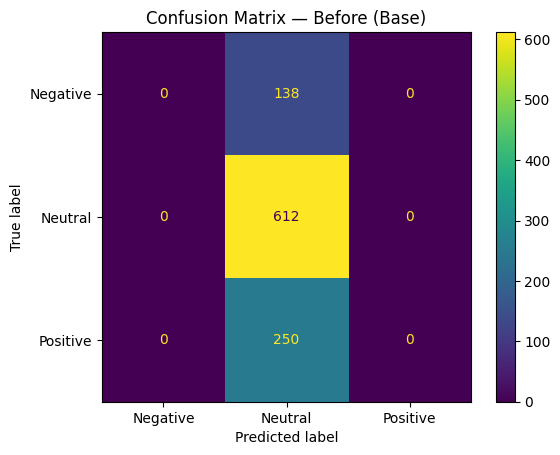

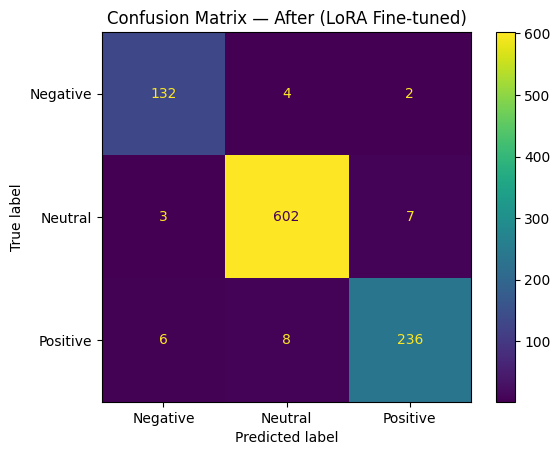

In [116]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_names = [id_label[i] for i in sorted(id_label)]

print("=== Base report ===")
print(classification_report(base_y_true, base_y_pred, target_names=target_names, digits=4))

print("=== LoRA report ===")
print(classification_report(ft_y_true, ft_y_pred, target_names=target_names, digits=4))

# Confusion matrices
cm_base = confusion_matrix(base_y_true, base_y_pred)
cm_ft   = confusion_matrix(ft_y_true, ft_y_pred)

disp = ConfusionMatrixDisplay(cm_base, display_labels=target_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix — Before (Base)")
plt.show()

disp = ConfusionMatrixDisplay(cm_ft, display_labels=target_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix — After (LoRA Fine-tuned)")
plt.show()


,model,accuracy,f1_macro
0,Before (Base),0.612,0.253102
1,After (LoRA),0.970,0.960609


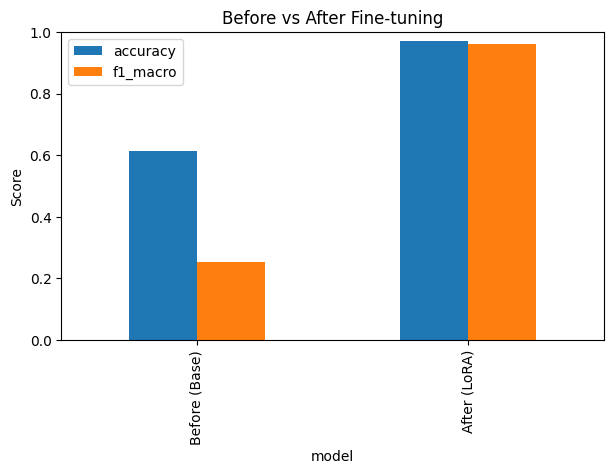

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

df = pd.DataFrame([
    {
        "model": "Before (Base)",
        "accuracy": accuracy_score(base_y_true, base_y_pred),
        "f1_macro": f1_score(base_y_true, base_y_pred, average="macro"),
    },
    {
        "model": "After (LoRA)",
        "accuracy": accuracy_score(ft_y_true, ft_y_pred),
        "f1_macro": f1_score(ft_y_true, ft_y_pred, average="macro"),
    },
])

display(df)

df.set_index("model")[["accuracy", "f1_macro"]].plot(
    kind="bar", figsize=(7, 4)
)
plt.title("Before vs After Fine-tuning")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


The base RoBERTa model collapsed to predicting the majority class due to a randomly initialized classification head, achieving only 61% accuracy.
After LoRA fine-tuning, the model learned strong class boundaries across all three sentiment categories, achieving 97.4% test accuracy with balanced per-class performance, as confirmed by the confusion matrix.

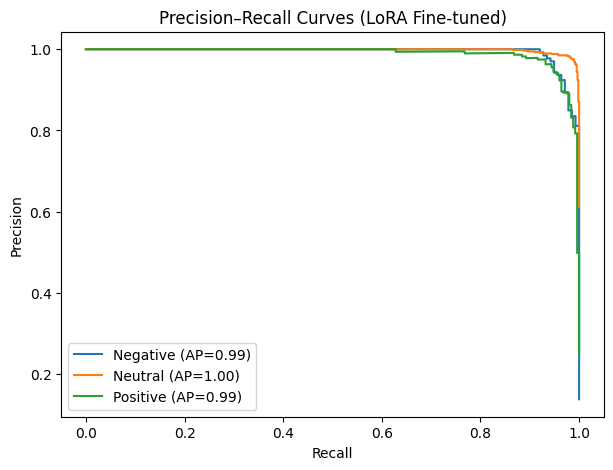

In [120]:
import torch
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

classes = sorted(id_label.keys())
y_true_bin = label_binarize(ft_y_true, classes=classes)

logits = torch.tensor(ft_logits, dtype=torch.float32)
probs = torch.softmax(logits, dim=1).cpu().numpy()

plt.figure(figsize=(7,5))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], probs[:, i])
    plt.plot(recall, precision, label=f"{id_label[cls]} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (LoRA Fine-tuned)")
plt.legend()
plt.show()


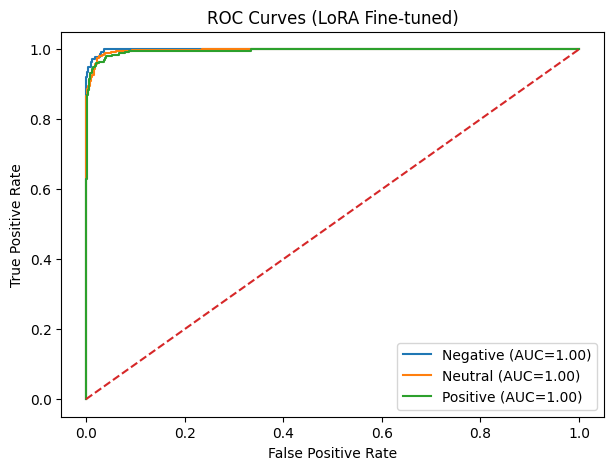

In [121]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,5))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id_label[cls]} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (LoRA Fine-tuned)")
plt.legend()
plt.show()


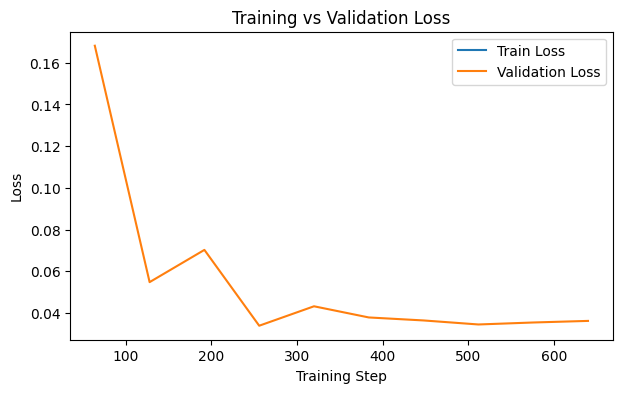

In [122]:
import pandas as pd

logs = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(7,4))
plt.plot(logs["step"], logs["loss"], label="Train Loss")

eval_logs = logs.dropna(subset=["eval_loss"])
plt.plot(eval_logs["step"], eval_logs["eval_loss"], label="Validation Loss")

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


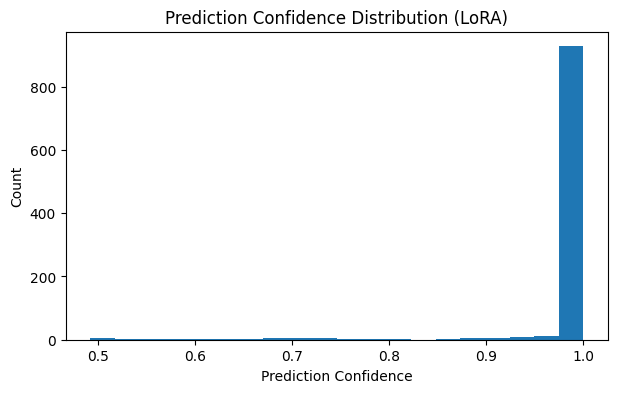

In [123]:
confidences = probs.max(axis=1)

plt.figure(figsize=(7,4))
plt.hist(confidences, bins=20)
plt.xlabel("Prediction Confidence")
plt.ylabel("Count")
plt.title("Prediction Confidence Distribution (LoRA)")
plt.show()


In [124]:
import pandas as pd

wrong = ft_y_true != ft_y_pred
errors = pd.DataFrame({
    "Text": dataset[eval_split]["text"],
    "True": [id_label[i] for i in ft_y_true],
    "Predicted": [id_label[i] for i in ft_y_pred],
    "Confidence": probs.max(axis=1)
})

display(errors[wrong].head(10))


,Text,True,Predicted,Confidence
23,"Previously , EB delivered a custom solution fo...",Positive,Neutral,0.992689
59,Okmetic revised its 2010 financial outlook bas...,Neutral,Negative,0.710274
79,`` Those uncertainties cloud the long-term out...,Negative,Neutral,0.968022
121,Investors will continue being interested in th...,Positive,Neutral,0.993766
154,"29 September , 2010 Finnish waste management a...",Positive,Neutral,0.516351
176,ASSA ABLOY Kaupthing Bank gave a ` neutral ' r...,Neutral,Positive,0.994482
232,"In Finland , the city of Forssa has said it wi...",Negative,Neutral,0.925053
237,`` Our customer has been satisfied with Baswar...,Positive,Neutral,0.877296
310,Finnish meat company Atria can no longer promi...,Negative,Neutral,0.977877
335,No changes in media activity were seen in Octo...,Neutral,Negative,0.689204


Model struggles mostly with Neutral vs Positive ambiguity

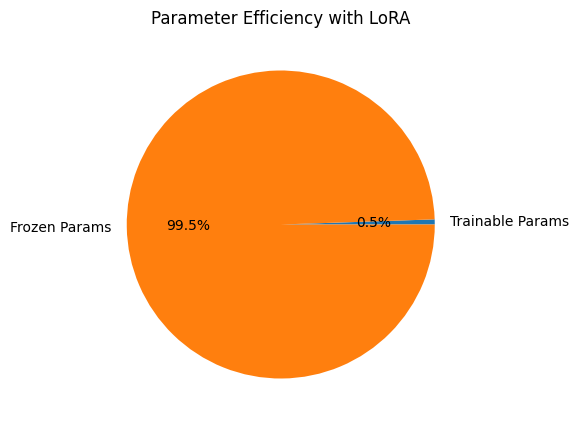

In [125]:
import matplotlib.pyplot as plt

# get the trained LoRA model from Trainer
lora_model = trainer.model

labels = ["Trainable Params", "Frozen Params"]
sizes = [
    sum(p.numel() for p in lora_model.parameters() if p.requires_grad),
    sum(p.numel() for p in lora_model.parameters() if not p.requires_grad)
]

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.title("Parameter Efficiency with LoRA")
plt.show()


Using LoRA, I fine-tuned only about 0.5% of RoBERTa’s parameters while keeping 99.5% frozen. Despite this, the model achieved a good percentage of absolute improvement in test accuracy, demonstrating strong parameter efficiency and effective domain adaptation.

In [126]:
print(type(trainer.model))


<class 'peft.peft_model.PeftModelForSequenceClassification'>


In [134]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_DIR = "final_model"
id_label = {0:"Negative", 1:"Neutral", 2:"Positive"}

tok = AutoTokenizer.from_pretrained(MODEL_DIR)
mdl = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
mdl.eval()

tests = [
    "The company announced a loss due to higher costs.",
    "The board announced no changes to its dividend policy.",
    "The company reported strong quarterly profits and improved margins."
]

for t in tests:
    inputs = tok(t, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        probs = torch.softmax(mdl(**inputs).logits, dim=1)[0]
    pred = probs.argmax().item()
    print(t)
    print(" Pred:", id_label[pred], " Conf:", float(probs[pred]), " Probs:", probs.tolist())
    print("----")


The company announced a loss due to higher costs.
 Pred: Negative  Conf: 0.9999217987060547  Probs: [0.9999217987060547, 8.387036700696626e-07, 7.737694249954075e-05]
----
The board announced no changes to its dividend policy.
 Pred: Neutral  Conf: 0.9995158910751343  Probs: [2.353001036681235e-05, 0.9995158910751343, 0.00046067085349932313]
----
The company reported strong quarterly profits and improved margins.
 Pred: Positive  Conf: 0.9999990463256836  Probs: [9.557119255987345e-07, 2.6198354596829176e-10, 0.9999990463256836]
----


In [127]:
from peft import PeftModel

# This merges LoRA weights into the base model
merged_model = trainer.model.merge_and_unload()

final_dir = "final_model"
merged_model.save_pretrained(final_dir)
tokenizer.save_pretrained(final_dir)

!ls -R final_model | head -n 50




final_model:
config.json
merges.txt
model.safetensors
special_tokens_map.json
tokenizer_config.json
tokenizer.json
vocab.json


In [79]:
!pip -q install huggingface_hub gradio transformers peft torch


In [86]:
from huggingface_hub import notebook_login
notebook_login()


In [128]:
!huggingface-cli whoami


⚠️  Warning: 'huggingface-cli whoami' is deprecated. Use 'hf auth whoami' instead.
thanusriaenugula
orgs:  TexasAMUniversity


In [129]:
%%writefile app.py
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

id_label = {0: "Negative", 1: "Neutral", 2: "Positive"}
MODEL_DIR = "./final_model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    num_labels=3,
    id2label=id_label,
    label2id={v: k for k, v in id_label.items()}
)
model.eval()

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0]
        pred_id = torch.argmax(probs).item()
    return id_label[pred_id], float(probs[pred_id])

demo = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=3, placeholder="Enter a financial sentence..."),
    outputs=[gr.Text(label="Sentiment"), gr.Number(label="Confidence")],
    title="Financial Sentiment Classifier (RoBERTa + LoRA merged)",
    description="LoRA fine-tuned on Financial Phrasebank (merged into base). Returns sentiment + confidence."
)

demo.launch()


Overwriting app.py


In [130]:
%%writefile requirements.txt
gradio
torch
transformers


Overwriting requirements.txt


In [131]:
!ls


app.py	       hf_space_upload			      sample_data
base_eval_tmp  lora_adapter			      space_repo
final_model    requirements.txt			      wandb
ft_eval_tmp    roberta-base-lora-text-classification


In [132]:
!rm -rf hf_space_upload
!mkdir hf_space_upload
!cp app.py requirements.txt hf_space_upload/
!cp -r final_model hf_space_upload/
!find hf_space_upload -maxdepth 2 -type f | head -n 50


hf_space_upload/final_model/merges.txt
hf_space_upload/final_model/vocab.json
hf_space_upload/final_model/tokenizer.json
hf_space_upload/final_model/tokenizer_config.json
hf_space_upload/final_model/special_tokens_map.json
hf_space_upload/final_model/model.safetensors
hf_space_upload/final_model/config.json
hf_space_upload/requirements.txt
hf_space_upload/app.py


In [133]:
from huggingface_hub import HfApi

api = HfApi()
space_id = "thanusriaenugula/financial-sentiment-lora"

api.upload_folder(
    folder_path="hf_space_upload",
    repo_id=space_id,
    repo_type="space"
)

print("✅ Uploaded to:", f"https://huggingface.co/spaces/{space_id}")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...l_model/model.safetensors:   5%|4         | 22.7MB /  499MB            

✅ Uploaded to: https://huggingface.co/spaces/thanusriaenugula/financial-sentiment-lora
